# Setup

In [1]:
import crispr as cr 
from crispr.crispr_class import Crispr
import pertpy as pt
import muon
import os
import pandas as pd
import numpy as np
from config import (files_data, col_cell_type_data, col_gene_symbols_data, 
                    assays_data, layer_perturbation_data,
                    col_perturbation_data, key_control_data, 
                    col_split_by_data, layer_perturbation_data,
                    label_perturbation_type_data, col_target_genes_data,
                    key_treatment_data, col_guide_rna_data, col_batch_data,
                    col_sample_id_data)

# Options
skip_preprocessing_clustering = False  # to skip these steps
print(dir(cr.ax))
# file = "CRISPRi_scr"
file = "CRISPRi_ess"
# file = "ECCITE"
# file = "augur_ex"
# file = "coda"
# file = "screen"
# file = "perturb-seq"

#  Set Arguments
col_cell_type = col_cell_type_data[file]
col_sample_id = col_sample_id_data[file]
col_perturbation = col_perturbation_data[file]
col_target_genes = col_target_genes_data[file]
key_control, label_perturbation_type, layer = [
    x[file] for x in [key_control_data, label_perturbation_type_data,
                      layer_perturbation_data]
]
col_gene_symbols = col_gene_symbols_data[file]
if file in assays_data:
    if isinstance(assays_data[file], str) or assays_data[file] is None:
        assays_data[file] = [assays_data[file], None]
    assay, assay_protein = assays_data[file]
else:
    assay, assay_protein = None
key_treatment = key_treatment_data[file]
col_split_by = col_split_by_data[file]
col_guide_rna = col_guide_rna_data[file]
layer_perturbation = layer_perturbation_data[file]
file_path = files_data[file]
col_batch = col_batch_data[file]
kwargs_init = dict(assay=assay, assay_protein=assay_protein,
                   col_gene_symbols=col_gene_symbols, 
                   col_cell_type=col_cell_type, col_sample_id=col_sample_id, 
                   col_perturbation=col_perturbation, col_guide_rna=col_guide_rna,
                   col_target_genes=col_target_genes, col_batch=col_batch,
                   layer_perturbation=layer_perturbation,
                   label_perturbation_type=label_perturbation_type,
                   key_control=key_control, key_treatment=key_treatment)
print(files_data)

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'analyze_composition', 'cluster', 'clustering', 'compute_distance', 'perform_augur', 'perform_differential_prioritization', 'perform_mixscape', 'perturbations']
{'CRISPRi_scr': '/home/asline01/projects/crispr/examples/data/crispr-screening/filtered_feature_bc_matrix_HH06.h5', 'CRISPRi_wgs': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_gwps.h5ad', 'CRISPRi_ess': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_esss.h5ad', 'pool': '/home/asline01/projects/crispr/examples/data/norman_2019_raw.h5ad', 'bulk': '/home/asline01/projects/crispr/examples/data/burczynski_crohn.h5ad', 'screen': '/home/asline01/projects/crispr/examples/data/dixit_2016_raw.h5ad', 'perturb-seq': '/home/asline01/projects/crispr/examples/data/adamson_2016_upr_perturb_seq.h5ad', 'ECCITE': '/home/asline01/projects/crispr/examples/data/papalexi_2021.h5ad', 'coda': '/hom

# Setup Object

## Instantiate

In [2]:
# Initialize Object
print(f"Initialization keyword arguments (from config):\n{kwargs_init}")
if skip_preprocessing_clustering:
    file_path_new = os.path.splitext(file_path)[0] + "_processed" + ".h5ad"
    if os.path.exists(file_path_new):
        file_path = os.path.splitext(file_path)[0] + "_processed" + ".h5ad"
    else:
        print(f"Can't skip. {file_path_new} does not exist.")
        skip_preprocessing_clustering
if file == "ECCITE":
    ann = Crispr(pt.data.papalexi_2021(), **kwargs_init)
elif file == "Adamson":
    ann = Crispr(pt.data.adamson_2016_upr_perturb_seq(), **kwargs_init)
else:
    ann = Crispr(file_path, **kwargs_init)
    
# Make New Variable/Subset Large Data
if file == "CRISPRi_ess":
    ann.adata.obs[ann._columns["col_target_genes"]] = ann.adata.obs[
        col_target_genes].astype(str).str.strip(" ").replace(
            "", ann._keys["key_control"]).replace(
                np.nan,  ann._keys["key_control"])
    ann.adata = ann.adata[ann.adata.obs["guide_ids"].isin(
        ["NT", "CDKN1A", "CDKN1A,CDKN1B", "CEBPA", "CEBPB", 
         "CEBPA,CEBPB", "CEBPB,OSR2", "S1PR2,SGK1",
         "DUSP9,KLF1", "SAMD1,UBASH3B", "TGFBR2", 
         "FEV,ISL2", "PRTG,TGFBR2",
         "JUN", "CLDN6,KLF1", "CBFA2T3,POU3F2", "FOXA1,HOXB9",
         "DLX2,ZBTB10", "SAMD1,TGFBR2", "ZBTB10", "CEBPE,SPI1", "PTPN13",
         "CEBPE,PTPN12", "CDKN1B,CDKN1C", "FOXF1,FOXL2", "AHR,FEV",
         "KLF1,TGFBR2", "CDKN1A,CDKN1B",])]  # subset for speed
    
# Add Control Keys Where Needed
if assay:
    ann.adata[assay].obs[ann._columns["col_perturbation"]] = ann.adata[
        assay].obs[ann._columns["col_perturbation"]].replace(
            "", np.nan).replace(np.nan, ann._keys["key_control"])
else:
    ann.adata.obs[ann._columns["col_perturbation"]] = ann.adata.obs[
        ann._columns["col_perturbation"]].replace("", np.nan).replace(
            np.nan, ann._keys["key_control"])
    
# Fix Gene Columns
if file == "coda": 
    ann.adata.var.loc[:, ann._columns[
        "col_gene_symbols"]] = ann.adata.var.index.values
if assay:
    if ann._columns["col_gene_symbols"] in ann.adata[assay].var.index.names:
        ann.adata[assay].var = ann.adata[assay].var.reset_index()
else:
    if ann._columns["col_gene_symbols"] in ann.adata.var.index.names:
        ann.adata.var = ann.adata.var.reset_index()
        
# Binary Perturbation Column      
if assay:
    conds = list(ann.adata[assay].obs[ann._columns[
        "col_perturbation"]].unique())
else:
    conds = list(ann.adata.obs[ann._columns[
        "col_perturbation"]].unique())
lab_tx = "Perturbed" if ann._keys[
    "key_treatment"] is None else ann._keys["key_treatment"]
if len(conds) > 2:
    if assay:
        ann.adata[assay].obs[ann._columns["col_perturbation"] + "_old"] = ann.adata[
            assay].obs[ann._columns["col_perturbation"]].copy()
        ann.adata[assay].obs[ann._columns[
            "col_perturbation"] + "_binary"] = ann.adata[
                assay].obs[ann._columns[
                    "col_perturbation"]].apply(
                        lambda x: lab_tx if x != ann._keys["key_control"] else x)
    else:
        ann.adata.obs[ann._columns["col_perturbation"] + "_old"] = ann.adata.obs[
            ann._columns["col_perturbation"]].copy()
        ann.adata.obs[ann._columns[
            "col_perturbation"] + "_binary"] = ann.adata.obs[
                ann._columns["col_perturbation"]].apply(
                    lambda x: lab_tx if x != ann._keys["key_control"] else x)
    ann._keys["key_treatment"] = lab_tx
else:
    if assay:
        ann.adata[assay].obs[ann._columns["col_perturbation"] + "_binary"] = ann.adata[
            assay].obs[ann._columns["col_perturbation"]].copy()
    else:
        ann.adata.obs[ann._columns["col_perturbation"] + "_binary"] = ann.adata.obs[
            ann._columns["col_perturbation"]].copy()

# Print
if assay:
    print(ann.adata.obs, "\n\n")
print(ann._columns, "\n\n")
print(ann._keys, "\n\n")
ann.adata[assay].obs if assay else ann.adata.obs

Initialization keyword arguments (from config):
{'assay': None, 'assay_protein': None, 'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': 'gemgroup', 'col_perturbation': 'guide_ids', 'col_guide_rna': 'guide_ids', 'col_target_genes': 'guide_ids', 'col_batch': 'gemgroup', 'layer_perturbation': 'X_pert', 'label_perturbation_type': 'KD', 'key_control': 'NT', 'key_treatment': None}
<<<CREATING OBJECT>>>

<<< LOADING FILE /home/asline01/projects/crispr/examples/data/replogle_2022_k562_esss.h5ad with sc.read()>>>


 AnnData object with n_obs × n_vars = 111445 × 33694
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2

,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells,guide_AHR,guide_ARID1A,guide_ARRDC3,...,guide_UBASH3A,guide_UBASH3B,guide_ZBTB1,guide_ZBTB10,guide_ZBTB25,guide_ZC3HAV1,guide_ZNF318,guide_ids,guide_ids_old,guide_ids_binary
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAGAAGC-1,NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0,1252,67,18.686567,1,True,2,0,0,0,...,0,0,0,0,0,0,0,NT,NT,NT
AAACCTGCACGAAGCA-1,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,958,39,24.564103,1,True,1,0,0,0,...,0,0,0,0,0,0,0,NT,NT,NT
AAACCTGGTATAATGG-1,NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0,552,26,21.230769,1,True,1,0,0,0,...,0,0,0,0,0,0,0,NT,NT,NT
AAACCTGTCACCGTAA-1,NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0,1463,92,15.902174,1,True,2,0,0,0,...,0,0,0,0,0,0,0,NT,NT,NT
AAACCTGTCCGATATG-1,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,2355,113,20.840708,1,True,1,0,0,0,...,0,0,0,0,0,0,0,NT,NT,NT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTACACCT-8,NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0,1875,93,20.161290,8,True,1,0,0,0,...,0,0,0,0,0,0,0,NT,NT,NT
TTTGTCACACGAGGTA-8,TGFBR2_NegCtrl0__TGFBR2_NegCtrl0,397,21,18.904762,8,True,1,0,0,0,...,0,0,0,0,0,0,0,TGFBR2,TGFBR2,Perturbed
TTTGTCAGTAGCGTGA-8,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,524,19,27.578947,8,True,1,0,0,0,...,0,0,0,0,0,0,0,NT,NT,NT


## Preprocess and Cluster

See `ann.figures[run_label]["clustering"]` (object attribute) or method output for figures.

You must set use_highly_variable to False if you don't want to filter by HVGs
and if you did not set kws_hvg to None or False in `.preprocess()`


In that scenario, the 'highly_variable' column in  will be created in `.obsm` 
during `.preprocess()` and then used by default in `.cluster`.

AnnData object with n_obs × n_vars = 18844 × 33694
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

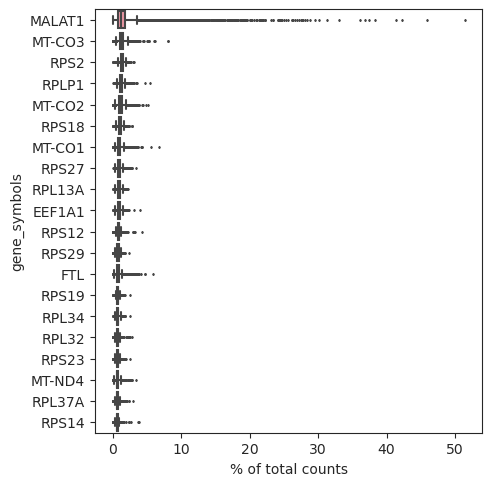


<<< FILTERING >>>

<<< DETECTING MITOCHONDRIAL GENES >>>

<<< PERFORMING QUALITY CONTROL >>>


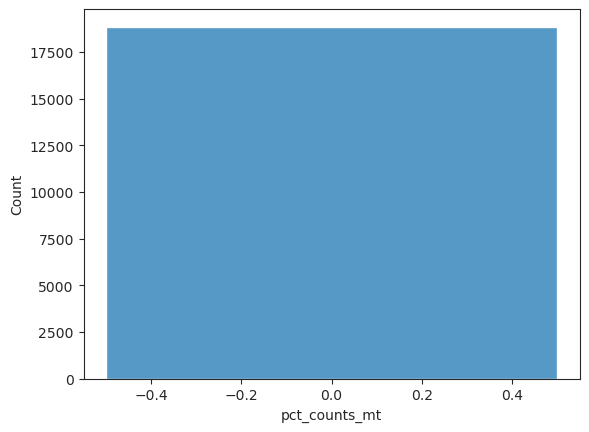

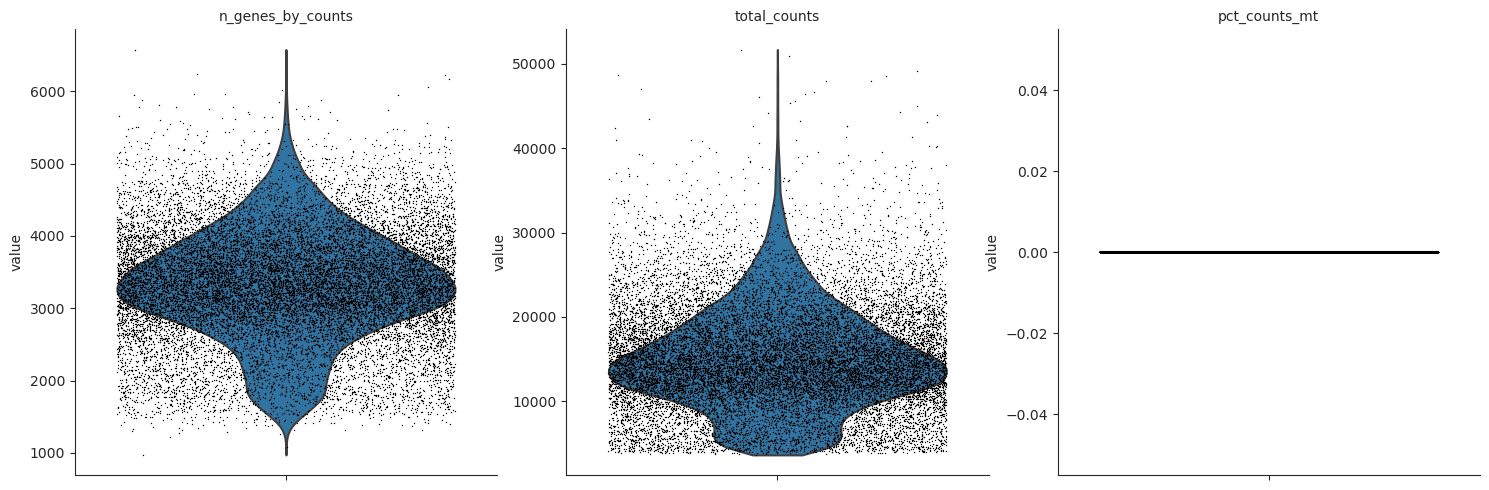

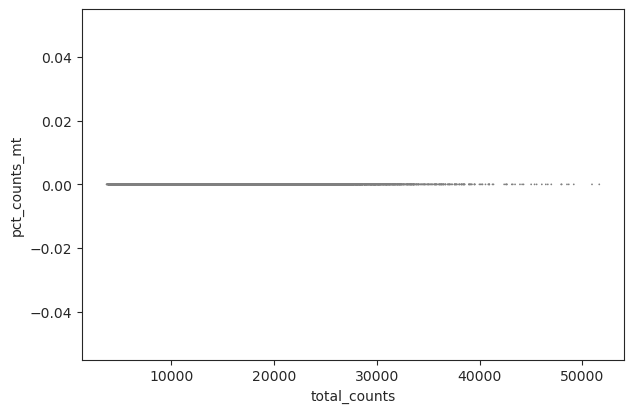

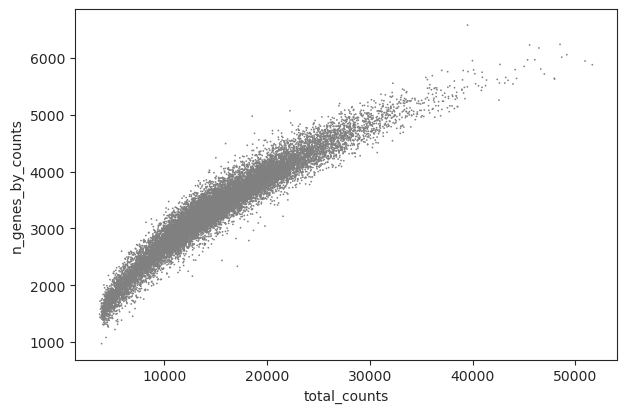


<<< NORMALIZING >>>

<<< DETECTING VARIABLE GENES >>>

<<< SCALING >>>



Un-used Keyword Arguments: {'col_cell_type': 'leiden', 'col_sample_id': 'gemgroup', 'col_batch': 'gemgroup', 'col_perturbation': 'guide_ids', 'col_guide_rna': 'guide_ids', 'col_target_genes': 'guide_ids', 'key_control': 'NT', 'key_treatment': 'Perturbed'}


<<< PERFORMING PCA >>>

 {'n_comps': None, 'use_highly_variable': True}


<<< COMPUTING NEIGHBORHOOD GRAPH >>>


<<< EMBEDDING: UMAP >>>


<<< CLUSTERING WITH LEIDEN METHOD >>>


<<< CREATING UMAP PLOTS >>>


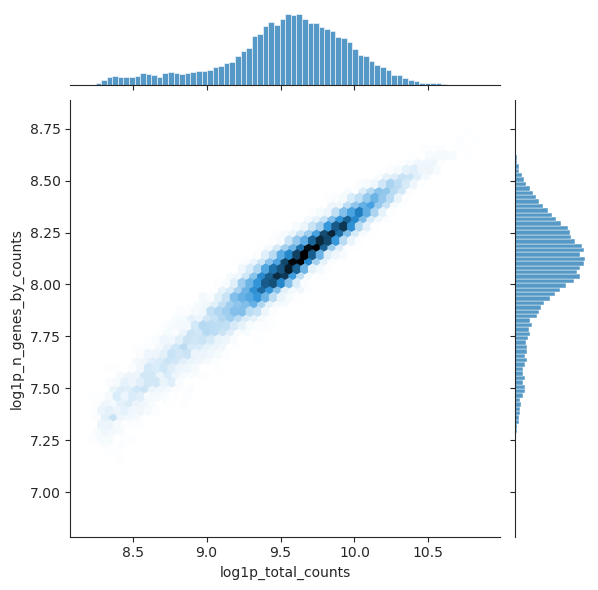

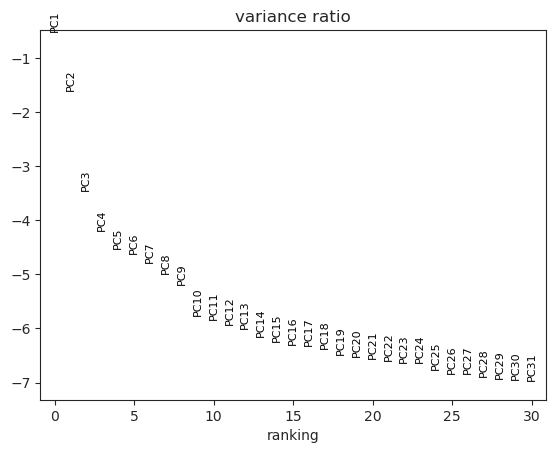

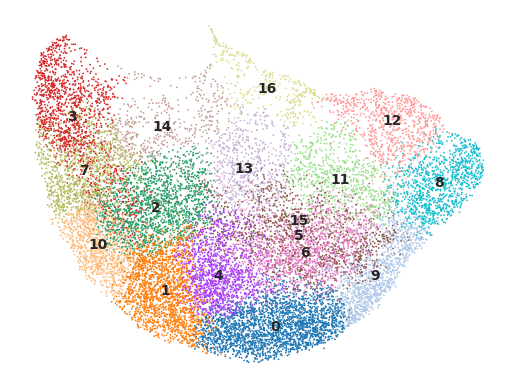

In [3]:
if not skip_preprocessing_clustering:
    # Filtering, Normalization, Scaling, QC
    cnfnd = None
    # cnfnd = ['total_counts', 'pct_counts_mt']
    # cnfnd=["total_counts", "pct_counts_mt", col_batch]
    process_kws = dict(kws_hvg=dict(min_mean=0.0125, max_mean=3, min_disp=0.5),
                       target_sum=1e4, max_genes_by_counts=2500, max_pct_mt=5, 
                       min_genes=200, min_cells=3, scale=10, regress_out=cnfnd)
    _ = ann.preprocess(**process_kws)  # preprocessing 
    kws_pca = dict(n_comps=None, use_highly_variable=True)

    # Clustering
    ann.cluster(paga=False, method_cluster="leiden",
                kws_pca=kws_pca, kws_neighbors=None, 
                kws_umap=None, kws_cluster=None)

# Analyses

## Augur: Cell Type-Level Perturbation Response

Which cell types are most affected by perturbations? Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of experimental condition labels (e.g., treated versus untreated). The more separable the condition among cells of a given type, the higher the perturbation effect score.

<u> __Features__ </u>  

- Quantify and visualize degree of perturbation response by cell type

<u> __Input__ </u>  

<u> __Output__ </u>  

mean_augur_score

<u> __Notes__ </u>  

- col_perturbation + "_binary"
- Sub-sample sizes equal across conditions; does not account for perturbation-induced compositional shifts (cell type abundance)
- Scores are for cell types (aggregated across cells, not individual cells)
- Two modes
    - If select_variance_feature=True, run the original Augur implementation, which removes genes that don't vary much across cell type.
    - If False, use features selected by `scanpy.pp.highly_variable_genes()`, which is faster and sensitively recovers effects; however, the feature selection may yield inflated Augur scores because this reduced feature set is used in training, resulting in it taking advantage of the pre-existing power of this feature selection to separate cell types.
    - If False, you also have to be sure that "highly_variable_features" is a variable in your data. This can be complicated if you have a separate layer for perturbation data.


Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_sample_id': 'gemgroup', 'col_batch': 'gemgroup', 'col_guide_rna': 'guide_ids', 'col_target_genes': 'guide_ids', 'layer': 'X_pert'}


Filtering samples with NT and Perturbed labels.

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

index
AAACCTGAGAAGAAGC-1-0     1
AAACCTGCACGAAGCA-1-0    11
AAACCTGGTATAATGG-1-0    11
AAACCTGTCACCGTAA-1-0     2
AAACCTGTCCGATATG-1-0     1
                        ..
TTTGGTTCATACGCTA-8-1    16
TTTGGTTCATTGGCGC-8-1     0
TTTGTCAAGCCACCTG-8-1     4
TTTGTCACACGAGGTA-8-1     8
TTTGTCAGTATAAACG-8-1     8
Name: cell_type, Length: 18844, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

                         1        11         2         8         0         6  \
mean_augur_score  0.488673  0.567075  0.540102  0.539807  0.529161  0.550476   
mean_auc          0.488673  0.567075  0.540102  0.539807  0.529161  0.550476   
mean_accuracy     0.486374  0.535531  0.515531  0.517839  0.516300  0.527216   
mean_precision    0.481395  0.543037  0.505696  0.529877  0.528197  0.535884   
mean_f1           0.431608  0.515589  0.478702  0.443676  0.478176  0.502532   
mean_recall       0.433333  0.533968  0.494762  0.433016  0.489841  0.519048   

                         3         9         7         4         5        10  \
mean_augur_score  0.552562  0.565669  0.483912  0.538345  0.516463  0.487052   
mean_auc          0.552562  0.565669  0.483912  0.538345  0.516463  0.487052   
mean_accuracy     0.532711  0.529780  0.482015  0.523773  0.490916  0.485824   
mean_precision    0.542221  0.555579  0.466483  0.530610  0.492789  0.490063   
mean_f1           0.502380  0.504351  0

KeyError: 'Could not find key augur_score in .var_names or .obs.columns.'

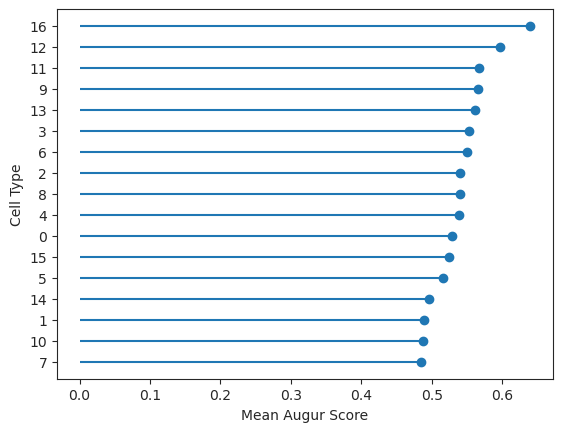

<Figure size 2183.4x480 with 0 Axes>

In [17]:
augur_data, augur_results, figs_augur = ann.run_augur(
    col_perturbation=ann._columns["col_perturbation"] + "_binary", 
    key_treatment=ann._keys["key_treatment"], 
    classifier="random_forest_classifier", 
    augur_mode="default", select_variance_features=True, n_folds=2,
    subsample_size=20, kws_augur_predict=dict(span=0.5))

## Mixscape: Cell-Level Perturbation Response

Which cell types are most affected by perturbations? Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of condition labels (e.g., treated versus untreated) and looking at how easy it is to tell perturbed versus non-perturbed (more separable = higher effect).

<u> __Features__ </u>  

- Remove confounds (e.g., cell cycle, batch effects)
- Classify cells as affected or unaffected (i.e., "escapees") by the perturbation
- Quantify and visualize degree of perturbation response

<u> __Input__ </u>  

<u> __Output__ </u>  
- Mixscape figures

<u> __Notes__ </u>  


In [20]:
# Choose a Random Subset of Target Genes (to save time)
if assay:
    if len(ann.adata[assay].obs[ann._columns[
        "col_target_genes"]].unique()) > 3:
        target_gene_idents = list(pd.Series(
            ann.adata[assay].obs[ann._columns[
                "col_target_genes"]].unique()).sample(3))
    else:
        target_gene_idents = True  # use all
else:
    if len(ann.adata.obs[ann._columns[
        "col_target_genes"]].unique()) > 3:
        target_gene_idents = list(pd.Series(
            ann.adata.obs[ann._columns[
                "col_target_genes"]].unique()).sample(3))
    else:
        target_gene_idents = True  # use all

# Run Mixscape
try:
    figs_mixscape = ann.run_mixscape(target_gene_idents=target_gene_idents)
except Exception as err:
    print(err)
    figs_mixscape = ann.run_mixscape()


Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'leiden', 'col_sample_id': 'gemgroup', 'col_batch': 'gemgroup'}


## Distance Metrics

See `ann.figures[run_label]["distances"]` and  `ann.results[run_label]["distances"]`
for results.


Un-used Keyword Arguments: {'col_gene_symbols': 'gene_symbols', 'col_sample_id': 'gemgroup', 'col_batch': 'gemgroup', 'col_guide_rna': 'guide_ids', 'col_target_genes': 'guide_ids', 'key_control': 'NT', 'key_treatment': 'Perturbed'}


Output()

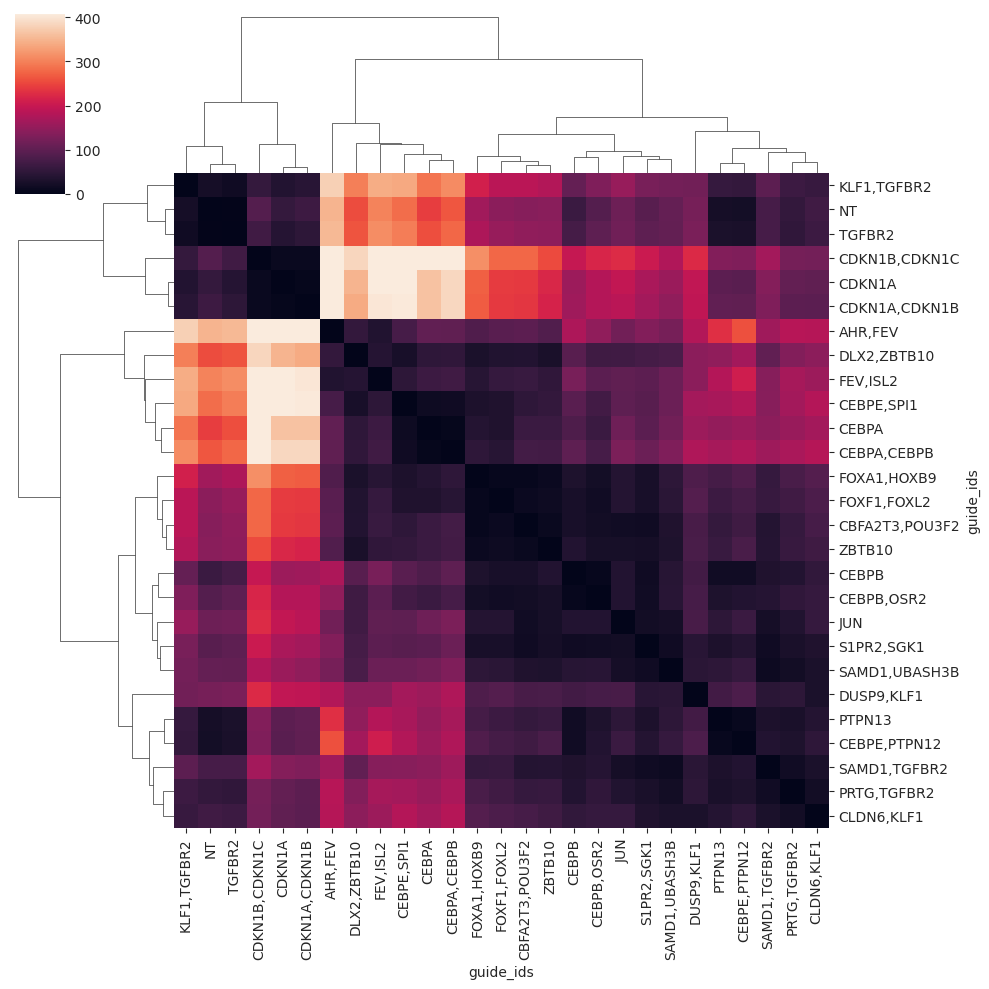

Output()

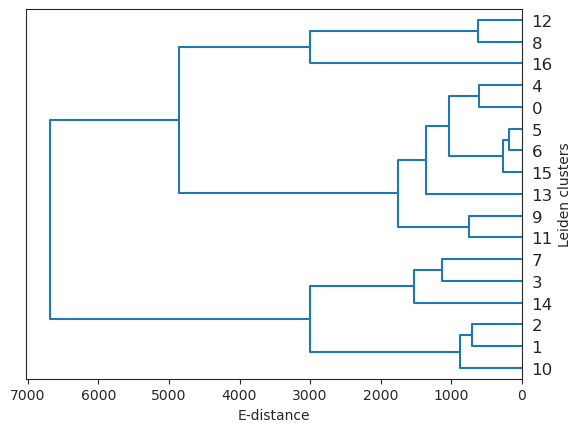

<Figure size 640x480 with 0 Axes>

In [4]:
fig_distance = ann.compute_distance(distance_type="edistance", method="X_pca")